# Capstone Project Module 3: Hotel Booking Demands Analysis

## Business Problem & Understanding

### Background

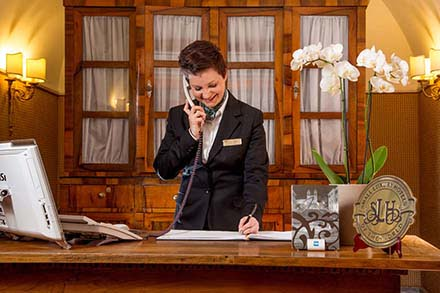

The hospitality industry is beset by a lot uncertainties, one of which is booking demands. As part of revenue management, hotel revenue management team must be able to accurately predict the amount of rooms checked-in with guests in any given day. Since hotel guests may cancel their booking prematurely, predicting how many rooms the guests will check in is a crucial step toward creating a stable revenue flow for any hotel.

To enhance any hotel's revenue management team decision-making processes, it falls to data scientists to analyze hotel booking data and implement machine learning algorithms to predict hotel booking cancellation. By analyzing booking dataset, which contains customer demographics, booking details, and reservation outcomes, one may derive key factors influencing hotel booking demand and cancellations to optimize its revenue management strategies. Consequently, what was once an exercise in rough guesswork in predicting the rate of cancelled booking may now be transformed into a machine learning classification problem that will have measurable impact and understandable model outcome in affecting daily hotel revenue.

### Problem Statement

Hotels face challenges in demand forecasting due to fluctuations in customer bookings and cancellations. Unanticipated cancellations result in **revenue losses**, **inefficient resource allocation**, and **decreased occupancy rates**. If cancellation trends are not accurately predicted, hotels may face difficulties in adjusting pricing strategies, implementing overbooking policies, and ensuring optimal room utilization.

Understanding customer behavior regarding cancellations is crucial for effective revenue management in the 21<sup>st</sup> century. A meta analysis of hotel revenue management peer-reviewed articles has corroborated that hotel revenue management team are shifting toward a more practical and strategic approach which incorporates big data analysis with machine learning model (Binesh et al., 2020). Consequently, a Machine Learning predictive model must be developed to identify patterns in customer bookings and cancellations, helping hotel revenue managers implement proactive strategies to **maximize occupancy rates and revenue**.

### Goals

The objective is to **maximize the accurate identification of hotel bookings that are likely to be canceled**, prioritizing machine learning model that correctly identify actual cancellations among all bookings that were truly canceled to minimize the risk of loss arising from overlooking potential cancellations.

This is achieved by analyzing a truncated historical booking dataset provided by Antonio et al. (2019), which includes customer and reservation attributes such as market segment, customer type, reserved room type, deposit status, previous cancellations, and total number of special requests. 

### Stakeholders

**Hotel Revenue Management Team**<br>
The primary stakeholder for this project is the Hotel Revenue Management Team, responsible for optimizing hotel revenue by managing pricing strategies, forecasting demand, and minimizing losses due to cancellations. They will use the predictive model to refine overbooking strategies, adjust pricing dynamically, and implement targeted promotions to reduce cancellations and maximize profitability.

### Analytical Approach

Building upon the works of previous data scientists such as Antonio et al (2017), Yaqi Lin (2023), and Rahmwati et al (2024), the dataset will be prepared for machine learning classification algorithms such as:
- XGBoost
- Logistic Regression
- Random Forest
- Light Gradient Boosting Model (LGBM)
- and many others...

before the best classification algorithm is chosen based on the accuracy of prediction and amount of time needed to fit the model.

### Metric Evaluation

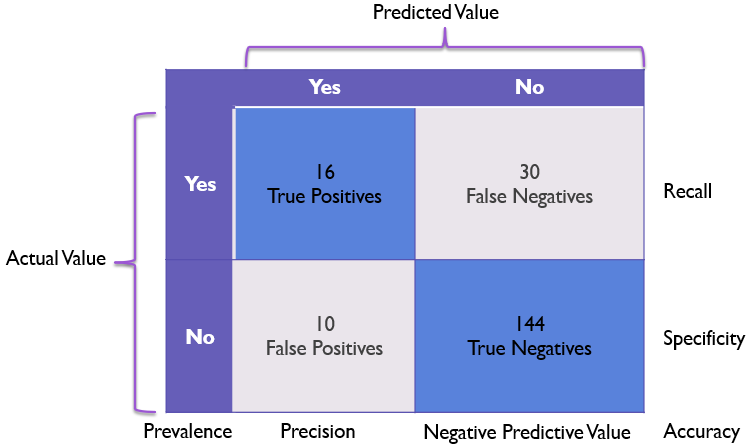

The primary evaluation metric for this classification model will be the **F2-Score**, a performance measure that emphasizes recall more than precision. The F2-Score is particularly relevant in hotel booking cancellation prediction because **it prioritizes correctly identifying bookings that are likely to be canceled**, reducing the risk of lost revenue due to unoccupied rooms.

The F2-Score is calculated as follows:

$$
F_2 = (1 + 2^2) \times \frac{(\text{Precision} \times \text{Recall})}{(2^2 \times \text{Precision} + \text{Recall})}
$$

Where:

- **Precision** represents the proportion of bookings predicted as cancellations that were actually canceled. A high precision ensures that hotels do not unnecessarily overbook based on false cancellation predictions.
- **Recall** measures the proportion of actual cancellations that were correctly predicted by the model. A high recall ensures that most cancellations are anticipated, allowing hotels to take proactive measures such as targeted offers, rebooking strategies, or adjusting overbooking limits.

Since predicting cancellations inaccurately can lead to financial losses, recall is more critical than precision in this case. Missing a potential cancellation (false negative) means the hotel may leave rooms unoccupied, directly impacting revenue. By focusing on recall-weighted F2-Score, the model ensures that hotels can effectively predict cancellations and make data-driven decisions to optimize occupancy rates and profitability.

## Library

In [1]:
import numpy as np 
import pandas as pd 
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# traintest split
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import chi2_contingency

#feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# ML algorithm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Evaluation
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, make_scorer, roc_auc_score
from sklearn.metrics import  classification_report, confusion_matrix, PrecisionRecallDisplay, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.utils.class_weight import compute_sample_weight
import shap

# Model Wrapper and Deployment
from models import AdjustedThresholdModel
import pickle
import streamlit as st

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Dataset

As previously mentioned, the dataset is sourced from [Kaggle website](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data), which was in turn adapted from an academic article titled ["Hotel Booking Demand Datasets"](https://www.sciencedirect.com/science/article/pii/S2352340918315191) authored by Antonio, Almeida, and Nunes (2019).

In [2]:
df = pd.read_csv("data_hotel_booking_demand.csv")
display(df.head(), df.tail())

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
83572,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1


### Dataset Attributes

| Column Name                   | Data Type    | Description |
|--------------------------------|-------------|-------------|
| `country`                        | Categorical  | Country of origin. |
| `market_segment`                 | Categorical  | Market segment designation. |
| `previous_cancellations`         | Integer      | Number of previous bookings that were cancelled by the customer prior to the current booking. |
| `booking_changes`                | Integer      | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation. |
| `deposit_type`                   | Categorical  | Indication on if the customer made a deposit to guarantee the booking. |
| `days_in_waiting_list`           | Integer      | Number of days the booking was in the waiting list before it was confirmed to the customer. |
| `customer_type`                  | Categorical  | Type of booking. |
| `reserved_room_type`             | Categorical  | Code of room type reserved. Code is presented instead of designation for anonymity reasons. |
| `required_car_parking_space`     | Integer      | Number of car parking spaces required by the customer. |
| `total_of_special_request`       | Integer      | Number of special requests made by the customer (e.g. twin bed or high floor). |
| `is_canceled`                    | Boolean      | Value indicating if the booking was canceled (1) or not (0). |


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


## Exploratory Data Analysis

In this section, the data will be visualized so that one can gain data understanding before implementing machine learning pipeline and algorithms.

First, the dataset will be checked for missing data.

In [4]:
listItem = []

# displaying the data type, missing value, unique value, and a few samples of the data
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)])

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[TJK, MDV]"
1,market_segment,object,0,0.00,8,"[Aviation, Corporate]"
2,previous_cancellations,int64,0,0.00,15,"[11, 1]"
3,booking_changes,int64,0,0.00,19,"[12, 6]"
4,deposit_type,object,0,0.00,3,"[Refundable, No Deposit]"
5,days_in_waiting_list,int64,0,0.00,115,"[65, 76]"
6,customer_type,object,0,0.00,4,"[Transient, Transient-Party]"
7,reserved_room_type,object,0,0.00,10,"[C, A]"
8,required_car_parking_spaces,int64,0,0.00,5,"[3, 8]"
9,total_of_special_requests,int64,0,0.00,6,"[0, 4]"


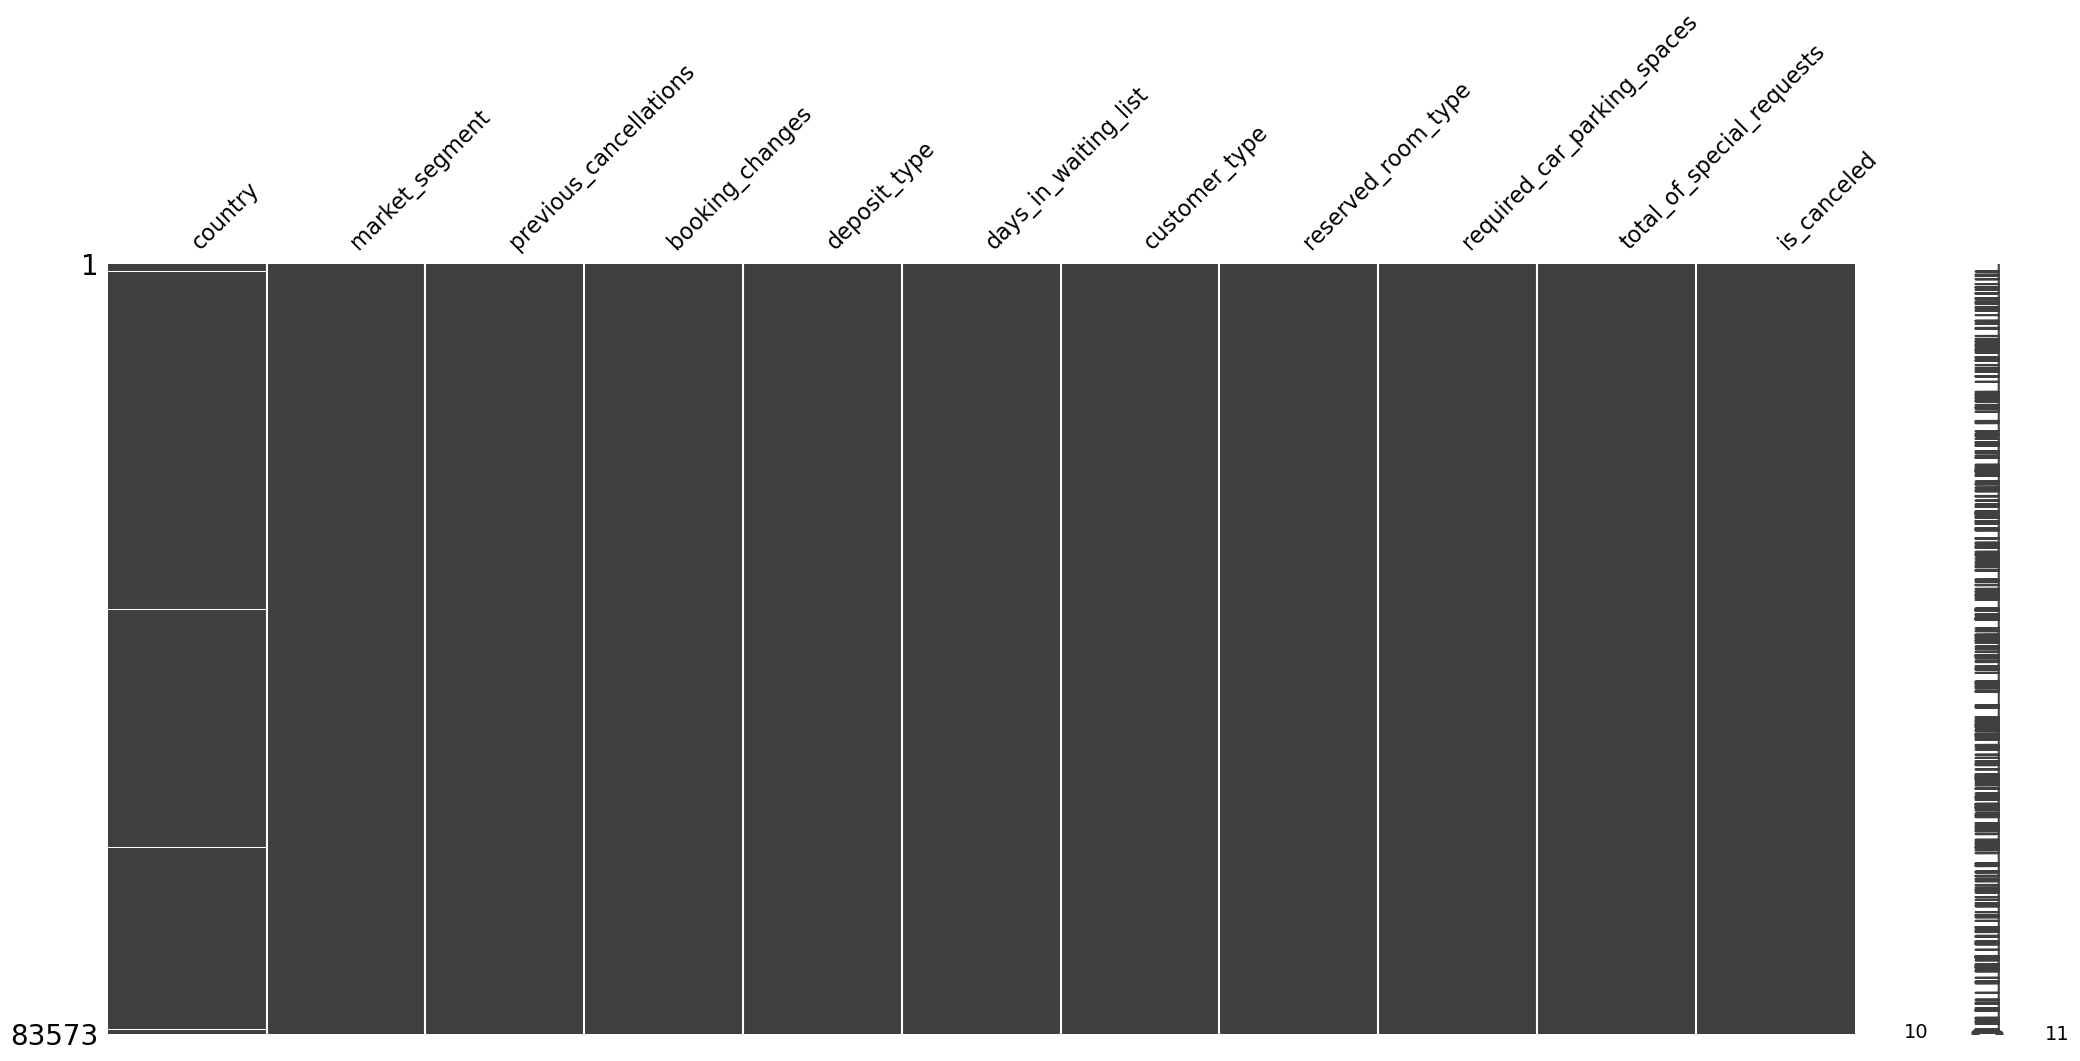

In [5]:
missingno.matrix(df)
plt.show()

Using visualization and dataframe tabulation, the column `country` contains all of the missing data. Normally, this can be treated by imputing values using methods such as `.fillna` method. 

However, Antonio et al. (2017) has revealed that the `country` column has mislabelling issue as 'Portugal' is assigned for each booking on creation time. Only on check-in did the hotel staff revised the `country` assignment based on the ID submitted by each traveller. As such, the column is dropped from the dataframe to prevent data leakage.

In [6]:
df = df.drop(columns = ['country'])
df.head()

,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


Next, the dataframe is checked for duplicated data.

In [7]:
df.duplicated().sum()

80714

While this amount of data duplication is concerning, it is important to remember that there may be repeat bookings with similar characteristics at different dates. As such, the duplicated data is kept for now.

Now, the distribution of data label (`is_cancelled`) is visualized using bar chart.

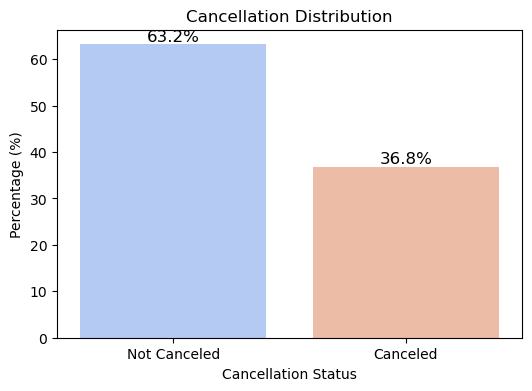

In [8]:
# Plot cancellation distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=df['is_canceled'], palette="coolwarm", stat='percent')

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')

plt.title("Cancellation Distribution")
plt.xlabel("Cancellation Status")
plt.xticks([0, 1], ["Not Canceled", "Canceled"])
plt.ylabel("Percentage (%)")

plt.show()

**Insight**
1. The target label `is_cancelled` has *imbalanced* data set, with only about $40\%$ of all bookings are cancelled.
2. In order to address the label imbalance, a **resampling** method will be utilized on machine learning pipeline.

Then, a series of visualizations is created to show the distribution for categorical features:

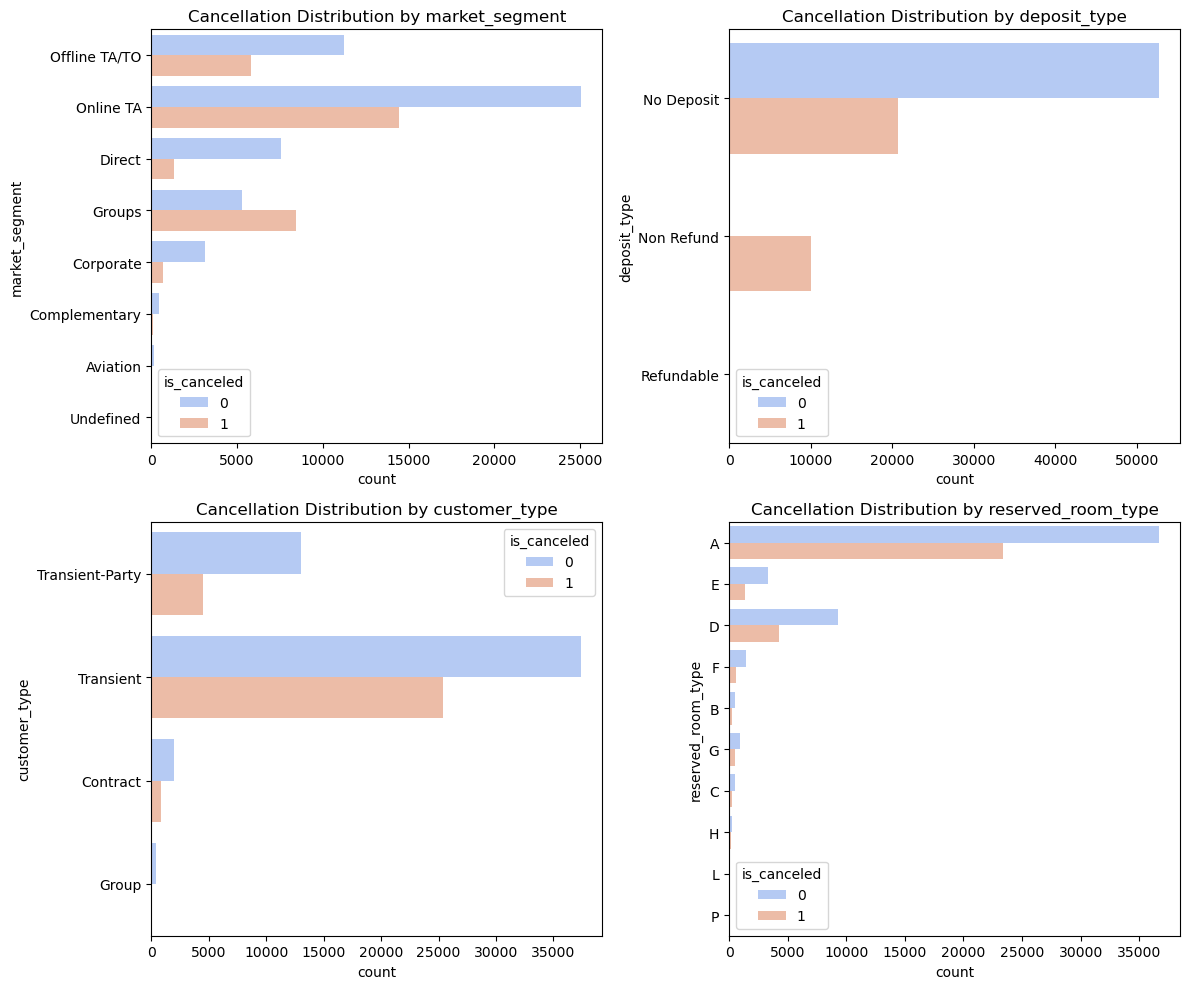

In [9]:
# Plot the distribution of categorical features
categorical_features = df.select_dtypes(include='object').columns.to_list()
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, feature in enumerate(categorical_features):
    ax = axes[i//2, i%2]
    total_counts = df[feature].value_counts().sum()
    
    sns.countplot(y=feature, data=df, hue="is_canceled", palette="coolwarm", ax=ax)

    ax.set_title(f"Cancellation Distribution by {feature}")

plt.tight_layout()
plt.show()

**Insight**
1. **High OTA Cancellations**: Online Travel Agency (OTA) bookings have the highest cancellation rates.  
2. **No Deposit = More Cancellations**: Most cancellations come from "No Deposit" bookings.  
3. **Transient Guests Are Unstable**: Transient customers cancel more than contract-based ones.  
4. **Room Type 'A' Cancels Most**: Popular but frequently canceled.

Next, boxplot visualizations for numerical columns of the dataset....

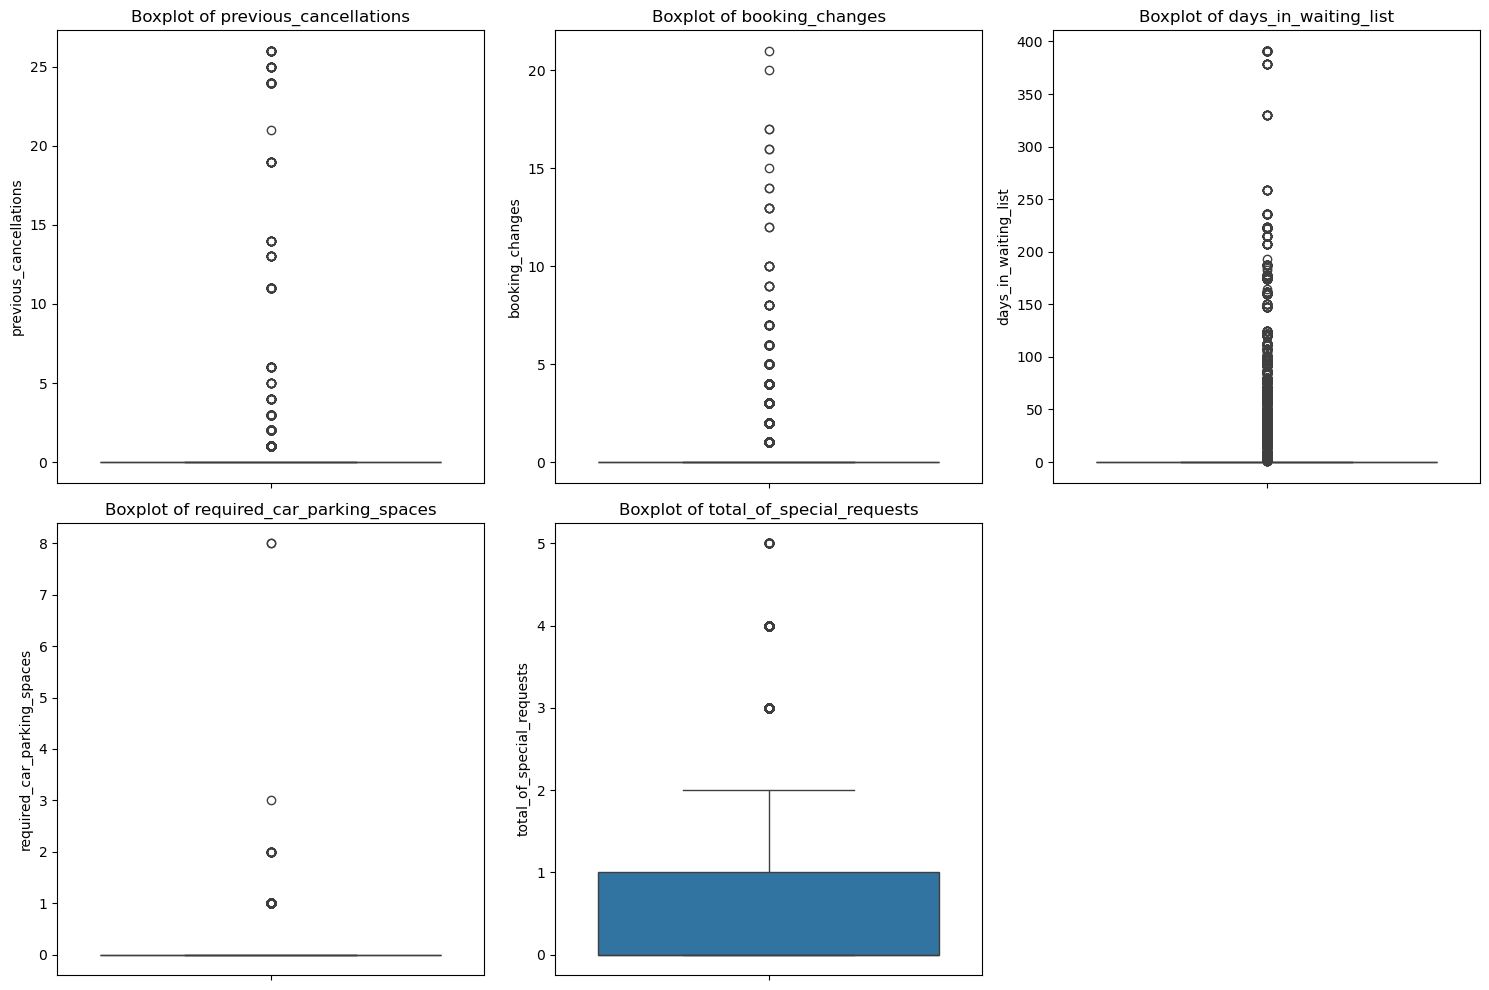

In [10]:
# Select only numerical columns for boxplots
numerical_columns = [col for col in df.select_dtypes(include=['number']).columns if col != 'is_canceled']

# Set up the figure and axis for subplots
num_cols = len(numerical_columns)
rows = (num_cols // 3) + (num_cols % 3 > 0)  # Arrange plots in rows of 3
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))
axes = axes.flatten()

# Create boxplots for each numerical column
for i, col in enumerate(numerical_columns):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)

# Remove unused subplots
for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

**Insight**
1. All numerical columns have a lot of outliers, necessating the need to implement **scaling** method on the machine learning pipeline

Finally, a heatmap correlation is produced using $Spearman's rank correlation$ method to check for **multicollinearity** amongst the features: 

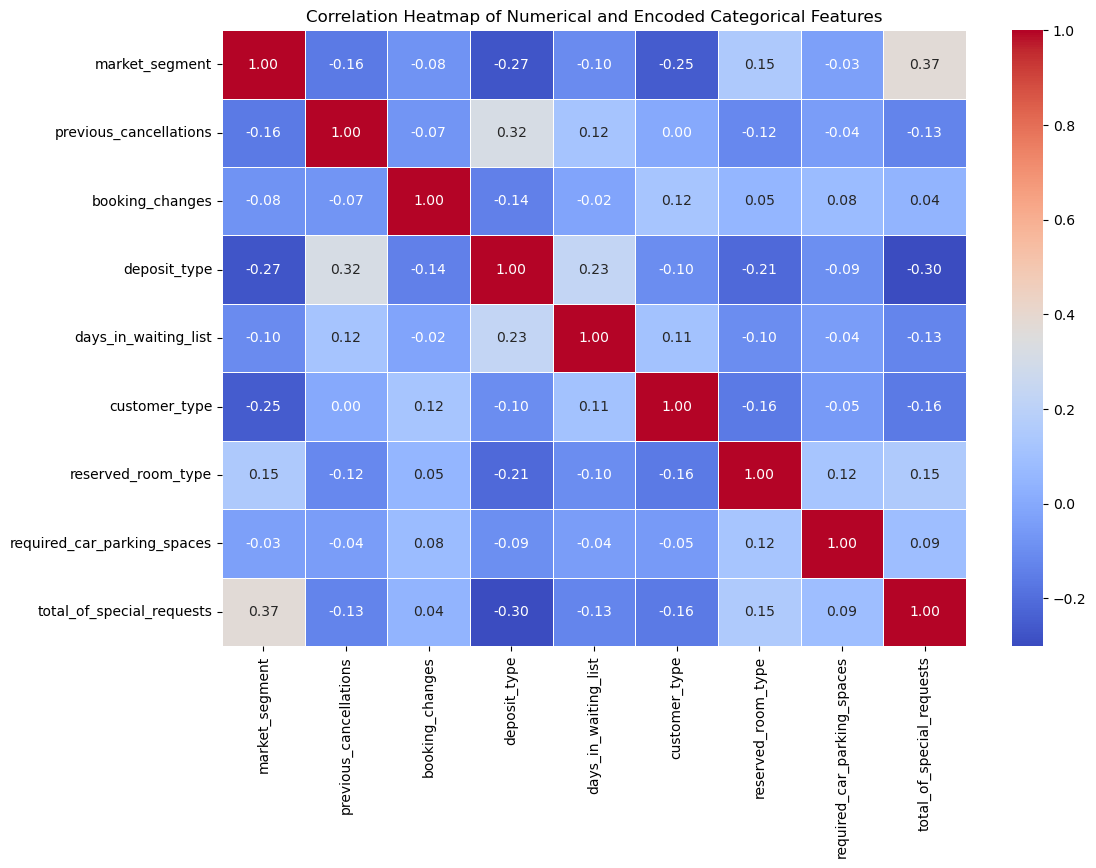

In [11]:
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Encode categorical columns using ordinal encoding
df_encoded = df.copy()
df_encoded.drop(columns=['is_canceled'], inplace=True)
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Compute correlation matrix
correlation_matrix = df_encoded.corr('spearman')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical and Encoded Categorical Features")
plt.show()

**Insight**
1. **Low Multicollinearity Overall**: Most correlation values are relatively low, indicating that the features do not exhibit strong multicollinearity. This suggests that the features contribute independently to the model.

## Modelling

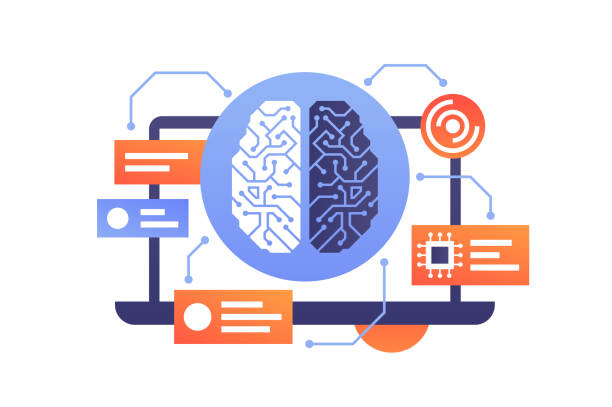

In this section, machine learning classification algorithms will be implemented on the dataset, and the resulting prediction will be evaluated using the chosen classification metric - $F2$.

### Pre-Modelling

Before the dataset is inserted into the machine learning pipeline, the dataset will be split into two groups: X for features and y for label. 

Then, the features and target label (`X`, `y`) will be further split usint the `train_test_method` from `sklearn` package to prevent **data leakage**, which is a condition that happens when information from outside the training dataset unfairly influences the model, leading to overly optimistic performance. 

In [12]:
# Separate features and target
X = df.drop(columns=["is_canceled"])
y = df["is_canceled"]

In [13]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Modelling (Without Hyperparameter Tuning)

In this section, the training dataset (`X_train` and `y_train`) will be fitted by 9 different machine learning algorithms:

- **Logistic Regression**: A linear model for binary classification that estimates probabilities using the logistic function.
- **Random Forest**: An ensemble learning method that constructs multiple decision trees and outputs the majority vote for classification.
- **Gradient Boosting**: A boosting algorithm that builds models sequentially, correcting previous errors to improve classification performance.
- **XGBoost**: An optimized gradient boosting algorithm designed for efficiency and speed, using tree-based learning with regularization.
- **LightGBM**: A gradient boosting framework that uses histogram-based learning for fast and efficient training on large datasets.
- **SGD SVM**: A linear Support Vector Machine trained using Stochastic Gradient Descent for scalable, high-dimensional classification.
- **Naive Bayes**: A probabilistic classifier based on Bayes' theorem, assuming feature independence for fast and simple classification.
- **KNN**: A non-parametric method that classifies based on the majority label of the k-nearest neighbors in feature space.

Before fitting, however, the training dataset will undergo several pre-processing steps within the `ImbPipeline` method which will include the following:

1. The training dataset is split between numerical and categorical features:
    - For numerical features, the training dataset will be imputed with median to handle missing values and will be scaled using `RobustScaler` method to account for outliers and non-normal distsribution
    - For categorical features, the training dataset will be imputed with mode to handle missing values and will be encoded using `OneHotEncoder` method so that the categorical values can be processed further
2. A feature selection using `SelectKBest` method will be conducted with `f_classif` parameter
3. Two resampling method, `SMOTE` and `RandomUnderSampler`, will be implemented separately for each classification algorithm to address label imbalance

After pre-processing, the training dataset will be fitted by one of the nine classification methods mentioned above, and each model $F2$ performance will be measured using the `cross_val_score` method.

Finally, the model with ranked according to the highest average $F2$ score, lowest standard deviation $F2$ score, and lowest fitting time. The top two models will be chosen for the next stage: **Hyperparameter Tuning**.

In [14]:
# Define categorical and numerical columns
num_features = X.select_dtypes(include=['number']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [15]:
# Preprocessing steps
numeric_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

In [16]:
# Feature selection
feature_selection = SelectKBest(score_func=f_classif)

In [17]:
# Resampling techniques
resampling_methods = {
    'SMOTE': SMOTE(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42)
}

In [18]:
# Classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'SGD SVM': SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
}

In [19]:
# Define F2 Score as the evaluation metric
f2_scorer = make_scorer(fbeta_score, beta=2, average='macro')

In [20]:
# Evaluating models
results_f2 = []

for resampling_name, resampler in resampling_methods.items():
    for clf_name, clf in classifiers.items():
        print(f"Evaluating {clf_name} with {resampling_name} resampling using F2 Score...")
        
        steps = [('preprocessor', preprocessor), ('feature_selection', feature_selection)]
        if resampler:
            steps.append(('resampling', resampler))
        steps.append(('classifier', clf))

        pipeline = ImbPipeline(steps=steps)

        start_time = time.time()
        f2_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=f2_scorer)
        exec_time = time.time() - start_time

        results_f2.append({
            'Resampling': resampling_name,
            'Classifier': clf_name,
            'F2 Score Mean': np.mean(f2_scores),
            'F2 Score Std': np.std(f2_scores),
            'Execution Time': exec_time
        })

Evaluating Logistic Regression with SMOTE resampling using F2 Score...
Evaluating Random Forest with SMOTE resampling using F2 Score...
Evaluating Gradient Boosting with SMOTE resampling using F2 Score...
Evaluating XGBoost with SMOTE resampling using F2 Score...
Evaluating LightGBM with SMOTE resampling using F2 Score...
[LightGBM] [Info] Number of positive: 33789, number of negative: 33789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 67578, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 33789, number of negative: 33789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007151 seconds.


In [21]:
# Convert results to DataFrame
results_f2_df = pd.DataFrame(results_f2)

# Sort results by F2 Score Mean (desc), F2 Score Std (asc), and Execution Time (asc)
sorted_results_f2_df = results_f2_df.sort_values(
    by=['F2 Score Mean', 'F2 Score Std', 'Execution Time'],
    ascending=[False, True, True]
).reset_index(drop=True)

# Display results
display(sorted_results_f2_df.head(5), sorted_results_f2_df.tail(5))

,Resampling,Classifier,F2 Score Mean,F2 Score Std,Execution Time
0,SMOTE,XGBoost,0.728732,0.004119,32.396321
1,SMOTE,LightGBM,0.728672,0.004309,32.907323
2,SMOTE,Random Forest,0.728654,0.003884,56.881753
3,RandomUnderSampler,LightGBM,0.728600,0.004471,3.424906
4,RandomUnderSampler,Random Forest,0.728535,0.003744,15.240193


,Resampling,Classifier,F2 Score Mean,F2 Score Std,Execution Time
11,RandomUnderSampler,SGD SVM,0.687843,0.012057,3.011760
12,SMOTE,KNN,0.679630,0.026170,105.175973
13,RandomUnderSampler,KNN,0.667976,0.005047,43.745230
14,SMOTE,Naive Bayes,0.557846,0.003587,32.289014
15,RandomUnderSampler,Naive Bayes,0.552191,0.004306,2.047784


**Insight**
1. XGBoost and LightGBM models with `SMOTE` resampling technique appear to dominate the ranking with the highest mean of $F2$ score, the lowest of $F2$ standard deviation, and the lowest execution time

For now, the two best models (which did not have their hyperparameters tuned) will be taken from the list of 9 models and fitted to the training dataset. The fitted model will in turn be used to predict the label on the test set and the resulting classification report will be printed.

In [22]:
# Select the top 2 models
top_2_models = sorted_results_f2_df.iloc[:2]  # Select the top 2 models

best_models = []
for index, row in top_2_models.iterrows():
    best_models.append({
        'Resampling': row['Resampling'],
        'Classifier': row['Classifier']
    })

print(f"Top 2 models: {best_models[0]['Classifier']} and {best_models[1]['Classifier']}")

Top 2 models: XGBoost and LightGBM


In [23]:
# Initialize a dictionary to store models and their test F2 scores
model_predictions = {}

for model_info in best_models:
    best_resampling = model_info['Resampling']
    best_classifier = model_info['Classifier']
    
    print(f"Training {best_classifier} with {best_resampling} resampling...")

    # Retrieve the classifier instance
    best_clf = classifiers[best_classifier]

    # Build the final pipeline
    final_steps = [('preprocessor', preprocessor), ('feature_selection', feature_selection)]

    # Add resampling if applicable
    if best_resampling != 'None':
        final_steps.append(('resampling', resampling_methods[best_resampling]))

    # Add the classifier
    final_steps.append(('classifier', best_clf))

    # Create the pipeline
    final_pipeline = ImbPipeline(steps=final_steps)

    # Fit the model
    final_pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = final_pipeline.predict(X_test)

    # Calculate F2 Score
    f2_test_score = fbeta_score(y_test, y_pred, beta=2, average='macro')
    
    # Store results
    model_predictions[best_classifier] = {
        'Predictions': y_pred,
        'F2 Score': f2_test_score
    }

Training XGBoost with SMOTE resampling...
Training LightGBM with SMOTE resampling...
[LightGBM] [Info] Number of positive: 42236, number of negative: 42236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 84472, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


F2 score for Light GBM is: 0.7275
Classification report for LightGBM is :
               precision    recall  f1-score   support

           0       0.79      0.82      0.81     10559
           1       0.67      0.63      0.65      6156

    accuracy                           0.75     16715
   macro avg       0.73      0.73      0.73     16715
weighted avg       0.75      0.75      0.75     16715



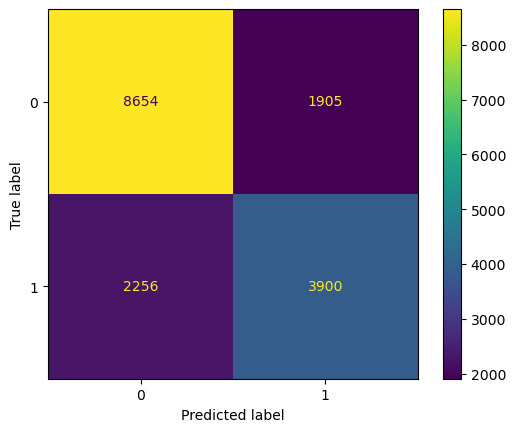

In [24]:
y_pred_lgbm = model_predictions['LightGBM']['Predictions']
f2_lgbm = model_predictions['LightGBM']['F2 Score']

print(f"F2 score for Light GBM is: {f2_lgbm:.4f}")
print(f"Classification report for LightGBM is :\n {classification_report(y_test, y_pred_lgbm)}")
display(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm))

F2 score for XGBoost is: 0.7274
Classification report for XGBoost is :
               precision    recall  f1-score   support

           0       0.79      0.82      0.81     10559
           1       0.67      0.63      0.65      6156

    accuracy                           0.75     16715
   macro avg       0.73      0.73      0.73     16715
weighted avg       0.75      0.75      0.75     16715



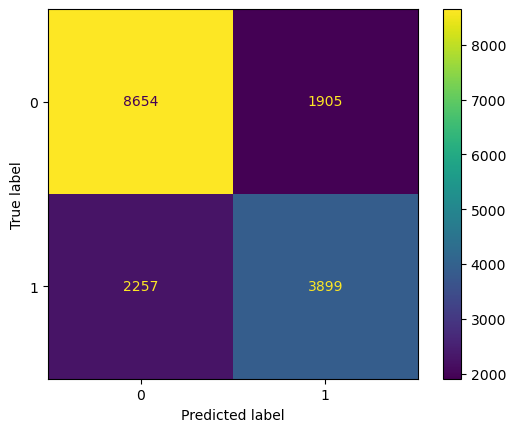

In [25]:
y_pred_xgb = model_predictions['XGBoost']['Predictions']
f2_xgb = model_predictions['XGBoost']['F2 Score']

print(f"F2 score for XGBoost is: {f2_xgb:.4f}")
print(f"Classification report for XGBoost is :\n {classification_report(y_test, y_pred_xgb)}")
display(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb))

It is evident from the $F2$ score and classification report that the two models (XGBoosts and LightGBM) show promising results in predicting booking cancellation.

### Modelling (With Hyperparameter Tuning)

With the two best models at hand, it is prudent to look further into how the models work so that one may understand how to tune the models to provide even better prediction results.

**XGBoost**

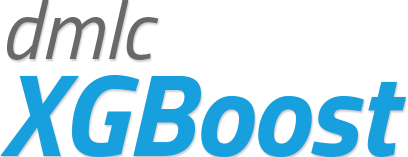

XGBoost (Extreme Gradient Boosting) is a powerful ensemble learning algorithm designed for structured data in classification and regression tasks. It builds decision trees sequentially, correcting errors from previous trees using gradient boosting. Unlike traditional methods, XGBoost is optimized with advanced regularization techniques (L1 and L2) to reduce overfitting and improve generalization. It utilizes second-order derivatives for better optimization, supports parallel computation for faster training, and efficiently handles missing values by learning optimal data splits dynamically.

A key advantage of XGBoost is its flexibility in hyperparameter tuning, allowing optimization of learning rate, tree depth, subsample ratio, and regularization terms for better performance. It also provides built-in feature importance analysis, aiding model interpretability. XGBoost supports various objective functions for classification and regression, making it ideal for applications like fraud detection, churn analysis, and demand forecasting. Its efficiency, scalability, and high predictive accuracy make it a preferred choice in machine learning competitions and real-world business scenarios.

**LightGBM**

![alt text](images/LightGBM_logo_black_text.svg)

LightGBM (Light Gradient Boosting Machine) is a high-speed gradient boosting framework optimized for large datasets. It uses a histogram-based approach to split data, reducing memory usage and computation time. Unlike traditional methods, LightGBM grows trees leaf-wise, expanding the leaf with the highest loss reduction, resulting in deeper trees with better accuracy. It also supports native categorical feature handling and GPU acceleration, making it highly efficient and scalable.

A key advantage of LightGBM is its ability to handle sparse data efficiently, making it ideal for tasks like recommendation systems and fraud detection. It offers extensive hyperparameter tuning, supports parallel and distributed computing, and balances accuracy with computational efficiency. Due to its speed, scalability, and high predictive performance, LightGBM is widely used in machine learning competitions and real-world business applications.

Using similar data pre-processing methods as before (imputation, scaling, encoding, feature selection, and resampling), three *hyperparameters* from each of the model will be manually tuned using the `gridsearchcv` method:

**XGBoost Hyperparameter Grid (`param_grid_xgb`)**
- `n_estimators`: Specifies the number of boosting rounds or trees in the ensemble. A higher value generally improves learning capacity but may lead to overfitting.
    - Values considered: 100, 200.
- `max_depth`: Defines the maximum depth of each tree. A larger depth allows the model to capture more complex patterns but increases the risk of overfitting.
    - Values considered: 3, 6.
- `learning_rate`: Controls the step size at which the model updates during training. Lower values make training more gradual and stable, reducing the risk of overfitting.
    - Values considered: 0.01, 0.1.

**LightGBM Hyperparameter Grid (`param_grid_lgbm`)**
- `n_estimators`: Similar to XGBoost, this parameter determines the number of boosting iterations.
    - Values considered: 100, 200.
- `num_leaves`: Represents the maximum number of leaves in a tree. Increasing this value allows for greater model complexity but may lead to overfitting.
    - Values considered: 31, 50.
- `learning_rate`: Regulates the rate at which the model learns from errors during training, balancing convergence speed and performance.
    - Values considered: 0.01, 0.1.

Additionally, the parameter `feature_selection__k` will have values of `[10, 15, 20]` for each parameter grid so that `SelectKBest` can be optimized to select the best number of features for each model.

In [26]:
# Define the imputer for numerical features
num_imputer = SimpleImputer(strategy="median")

# Define the imputer for categorical features
cat_imputer = SimpleImputer(strategy="most_frequent")

# Create a pipeline for numerical features
num_pipeline = ImbPipeline([
    ('imputer', num_imputer),
    ('scaler', RobustScaler())
])

# Create a pipeline for categorical features
cat_pipeline = ImbPipeline([
    ('imputer', cat_imputer),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing: Imputation, Scaling for numerical and OneHotEncoding for categorical
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [27]:
# Feature selection
feature_selector = SelectKBest(score_func=f_classif)  # Adjust k as needed

# Define resampling method
smote = SMOTE(random_state=42)

# Define classifiers
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=0, tree_method='hist')
lgbm = LGBMClassifier(random_state=42)

# Define scoring metric (F2 Score)
f2_scorer = make_scorer(fbeta_score, beta=2)

In [28]:
# Define pipeline
pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('smote', smote),
    ('classifier', xgb)
])

pipeline_lgbm = ImbPipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('smote', smote),
    ('classifier', lgbm)
])

In [29]:
# Define hyperparameter tuning grid
param_grid_xgb = {
    'feature_selection__k': [10, 15, 20],  
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6],
    'classifier__learning_rate': [0.01, 0.1]
}

param_grid_lgbm = {
    'feature_selection__k': [10, 15, 20],
    'classifier__n_estimators': [100, 200],
    'classifier__num_leaves': [31, 50],
    'classifier__learning_rate': [0.01, 0.1]
}

In [30]:
# Measure time for XGB model training
start_time_xgb = time.time()
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, scoring=f2_scorer, cv=3, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
end_time_xgb = time.time()
time_xgb = end_time_xgb - start_time_xgb

In [31]:
# Measure time for LGBM model training
start_time_lgbm = time.time()
grid_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, scoring=f2_scorer, cv=3, n_jobs=-1)
grid_lgbm.fit(X_train, y_train)
end_time_lgbm = time.time()
time_lgbm = end_time_lgbm - start_time_lgbm

[LightGBM] [Info] Number of positive: 42236, number of negative: 42236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 84472, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [32]:
# Get best results
best_xgb = grid_xgb.best_estimator_
best_tree = best_lgbm = grid_lgbm.best_estimator_

In [33]:
# Compare best models based on mean and std of F2 score
results = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM'],
    'Mean F2 Score': [grid_xgb.best_score_, grid_lgbm.best_score_],
    'Std F2 Score': [grid_xgb.cv_results_['std_test_score'][grid_xgb.best_index_], 
                     grid_lgbm.cv_results_['std_test_score'][grid_lgbm.best_index_]],
    'Execution Time (seconds)': [time_xgb, time_lgbm]
})

print("Model Performance Comparison:")
display(results)

Model Performance Comparison:


,Model,Mean F2 Score,Std F2 Score,Execution Time (seconds)
0,XGBoost,0.670714,0.007394,102.668101
1,LightGBM,0.663994,0.009654,178.274542


Using the same comparison method as before, the two models will go head-to-head (programmatically) in terms of average of $F2$ score, standard deviation of $F2$ score, and the amount time for fitting the model.

In [34]:
# Define selection criteria
best_model = None

# Extract comparison metrics
xgb_mean_f2 = results.loc[results['Model'] == 'XGBoost', 'Mean F2 Score'].values[0]
lgbm_mean_f2 = results.loc[results['Model'] == 'LightGBM', 'Mean F2 Score'].values[0]

xgb_std_f2 = results.loc[results['Model'] == 'XGBoost', 'Std F2 Score'].values[0]
lgbm_std_f2 = results.loc[results['Model'] == 'LightGBM', 'Std F2 Score'].values[0]

xgb_time = results.loc[results['Model'] == 'XGBoost', 'Execution Time (seconds)'].values[0]
lgbm_time = results.loc[results['Model'] == 'LightGBM', 'Execution Time (seconds)'].values[0]

# Model selection logic
if xgb_mean_f2 > lgbm_mean_f2 and xgb_std_f2 <= lgbm_std_f2:
    best_model = best_xgb
    best_model_name = "XGBoost"
elif lgbm_mean_f2 > xgb_mean_f2 and lgbm_std_f2 <= xgb_std_f2:
    best_model = best_lgbm
    best_model_name = "LightGBM"
elif xgb_mean_f2 > lgbm_mean_f2 and (xgb_mean_f2 - lgbm_mean_f2) > 0.01:  # Prefer higher F2
    best_model = best_xgb
    best_model_name = "XGBoost"
elif lgbm_mean_f2 > xgb_mean_f2 and (lgbm_mean_f2 - xgb_mean_f2) > 0.01:  # Prefer higher F2
    best_model = best_lgbm
    best_model_name = "LightGBM"
elif abs(xgb_mean_f2 - lgbm_mean_f2) <= 0.01:  # If F2 scores are very close
    if lgbm_time < xgb_time:  # Prefer the faster model
        best_model = best_lgbm
        best_model_name = "LightGBM"
    else:
        best_model = best_xgb
        best_model_name = "XGBoost"

# Output results
print("\nFinal Decision Based on Mean F2 Score, Std Dev, and Execution Time:")
print(f"XGBoost - Mean F2: {xgb_mean_f2:.4f}, Std F2: {xgb_std_f2:.4f}, Time: {xgb_time:.2f}s")
print(f"LightGBM - Mean F2: {lgbm_mean_f2:.4f}, Std F2: {lgbm_std_f2:.4f}, Time: {lgbm_time:.2f}s")
print(f"\nSelected Best Model: {best_model_name}")


Final Decision Based on Mean F2 Score, Std Dev, and Execution Time:
XGBoost - Mean F2: 0.6707, Std F2: 0.0074, Time: 102.67s
LightGBM - Mean F2: 0.6640, Std F2: 0.0097, Time: 178.27s

Selected Best Model: XGBoost


**XGBoost** model comes out ahead as the better classification model based on the aforementioned criteria.

The following code cells will delve further into the the XGBoost model as it is fitted on the training set with the best hyperparameters found during the hyperparameter tuning phase, and the resulting prediction from the testing dataset (`X_test`) will be evaluated against the testing label (`y_test`) to determine the $F2$ score, with accompanying display of **Precision-Recall Curve** and **ROC Curve**.

In [35]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [36]:
best_model.fit(X_train, y_train)
best_model_pred = best_model.predict(X_test)

In [37]:
print("F2 score on test set:", f"{f2_scorer(best_model, X_test, y_test):.4f}")
print(classification_report(y_test, best_model_pred))

F2 score on test set: 0.6633
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     10559
           1       0.72      0.65      0.68      6156

    accuracy                           0.78     16715
   macro avg       0.77      0.75      0.76     16715
weighted avg       0.78      0.78      0.78     16715



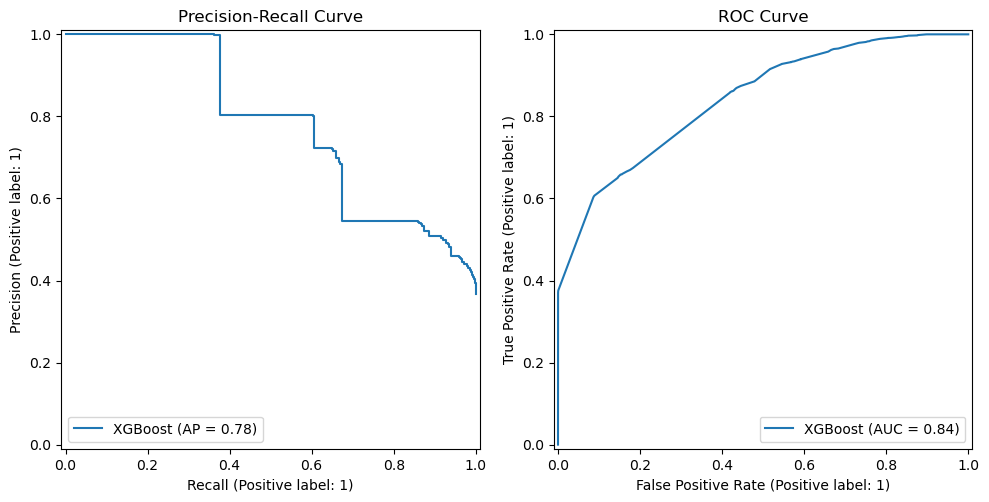

In [38]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, name=f'{best_model_name}', pos_label=1, ax=plt.gca())
plt.title("Precision-Recall Curve")

plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(best_model, X_test, y_test, name=f'{best_model_name}', pos_label=1, ax=plt.gca())
plt.title("ROC Curve")

plt.tight_layout()
plt.show()

**Insight**

1. The LightGBM model performs reasonably well in predicting hotel booking cancellations, with an **Area-Under-Curve** ($AUC$) of **0.84** and an **Area-Under-Precision-Recall-Curve** ($AP$) of **0.78**.
2. The **Precision-Recall** ($PR$) curve suggests that at some decision thresholds, precision drops significantly, which should be considered when setting the model’s cutoff to maximize $F2$ score

Since the resulting $F2$ score is *lower* after conducting hyperparameter tuning, it is clear that adjusting probability treshold is necessary to boost the $F2$-score and meet the business goal.

### Modelling (Threshold Adjustment)

**Probability threshold adjustment** is a technique used to optimize classification performance by selecting an appropriate probability threshold for converting predicted probabilities into class labels. 

In the following code cells, the predicted probabilities from the tuned XGBoost model are compared against various thresholds ranging from 0.1 to 0.9 in increments of 0.05. For each threshold, the $F2$-score— which prioritizes recall over precision— is computed and stored. The optimal threshold is determined by selecting the value that yields the highest $F2$-score. 

The optimal threshold is then used to generate the final predictions, improving model performance based on the chosen metric. Finally, A visualization of F2-score versus each threshold will illustrate the impact of threshold selection on model performance.

In [39]:
# Get probability predictions from LightGBM
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Define different threshold values
thresholds = np.arange(0.1, 0.9, 0.05)

# Store F2 scores for different thresholds
f2_scores = []

for threshold in thresholds:
    y_pred_adjusted = (y_probs >= threshold).astype(int)
    f2 = fbeta_score(y_test, y_pred_adjusted, beta=2)
    f2_scores.append(f2)

In [40]:
# Find the best threshold with highest F2 Score
best_threshold = thresholds[np.argmax(f2_scores)]
best_f2_score = max(f2_scores)

# Apply the best threshold
y_pred_best_threshold = (y_probs >= best_threshold).astype(int)

# Print the best threshold and corresponding F2 Score
print(f"Best Decision Threshold: {best_threshold:.2f}")
print(f"Improved F2 Score: {best_f2_score:.4f}")
print(f"Classification report for the adjusted threshold: \n{classification_report(y_test, y_pred_best_threshold)}")

Best Decision Threshold: 0.35
Improved F2 Score: 0.7897
Classification report for the adjusted threshold: 
              precision    recall  f1-score   support

           0       0.92      0.44      0.59     10559
           1       0.49      0.93      0.64      6156

    accuracy                           0.62     16715
   macro avg       0.70      0.68      0.62     16715
weighted avg       0.76      0.62      0.61     16715



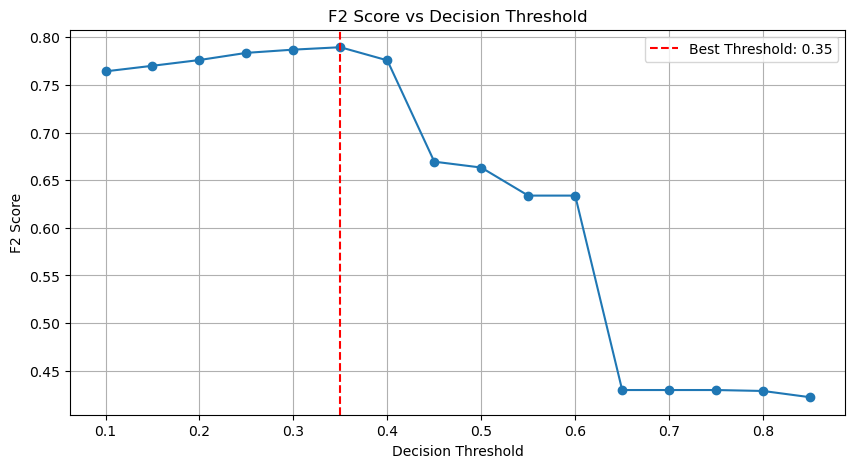

In [41]:
# Plot F2 Score vs Decision Threshold
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f2_scores, marker='o', linestyle='-')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel("Decision Threshold")
plt.ylabel("F2 Score")
plt.title("F2 Score vs Decision Threshold")
plt.legend()
plt.grid()
plt.show()

**Insight**

- The optimal threshold chosen is **0.35**, which means that if the XGBoost model predicts the probability of room cancellation to be above **35%**, then the model will consider the booking to be cancelled. Beyond 0.4, the model becomes too conservative, leading to a decline in $F2$-score and missing high-risk bookings.
- After hyperparameter tuning and threshold adjustment, the model's $F2$ score is **0.7897**, indicating that the model has a fairly good balance between precision and recall, where the model can accurately predict about **79%** of the number of actual booking cancellation, while minimizing the number of falsely predicted booking cancellation.
- The newly adjusted model has a recall score of **0.93** indicating that of all bookings which were actually cancelled, the model was able to correctly classify about **93%** of them as cancelled

### Modelling (Implementing Adjusted Treshold)

After calculating the optimal probability threshold, the tuned XGBoost model is wrapped using a wrapper class `AdjustedThresholdModel` to modify the probability threshold onn the tuned XGBoost model.

```python
class AdjustedThresholdModel:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold
    
    def predict(self, X):
        """Predict using adjusted threshold"""
        probabilities = self.model.predict_proba(X)[:, 1]  # Get probabilities for class 1
        return (probabilities >= self.threshold).astype(int)  # Apply threshold

    def predict_proba(self, X):
        """Return original probability scores"""
        return self.model.predict_proba(X)

In [42]:
# Instantiate the modified model with the adjusted threshold
best_model_adjusted = AdjustedThresholdModel(best_model, best_threshold)

# Example: Use the adjusted model for predictions
y_pred_adjusted = best_model_adjusted.predict(X_test)

# Print f2 score and classification report with new threshold
print(f"F2 Score with adjusted model: {f2_scorer(best_model_adjusted, X_test, y_test):.4f}")
print("\nClassification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

F2 Score with adjusted model: 0.7897

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.92      0.44      0.59     10559
           1       0.49      0.93      0.64      6156

    accuracy                           0.62     16715
   macro avg       0.70      0.68      0.62     16715
weighted avg       0.76      0.62      0.61     16715



In [43]:
best_model_adjusted.model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

## Model Evaluation

In this section, the resulting model (`best_model_adjusted`) will be evaluated from its features, business outcomes, and its limitation.

### Feature Evaluation

The features from `best_model_adjusted` will be examined from using the feature importance and SHAP value plots.

In [44]:
# Extract the SelectKBest step
select_k_best = best_model_adjusted.model.named_steps['feature_selection']

# Extract the column transformer step
column_transformer = best_model_adjusted.model.named_steps['preprocessor']

# Get the feature names after one-hot encoding
num_feature_names= column_transformer.named_transformers_['num'].get_feature_names_out(['previous_cancellations',
                                                                                           'booking_changes',
                                                                                           'days_in_waiting_list',
                                                                                           'required_car_parking_spaces',
                                                                                           'total_of_special_requests'])
cat_feature_names= column_transformer.named_transformers_['cat'].get_feature_names_out(['market_segment', 'deposit_type', 
                                                                                        'customer_type', 'reserved_room_type'])

feat_cols=list(num_feature_names)+list(cat_feature_names)

select_k_best.get_feature_names_out(feat_cols)

array(['previous_cancellations', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'deposit_type_No Deposit', 'deposit_type_Non Refund',
       'customer_type_Contract', 'customer_type_Group',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'reserved_room_type_A', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F'], dtype=object)

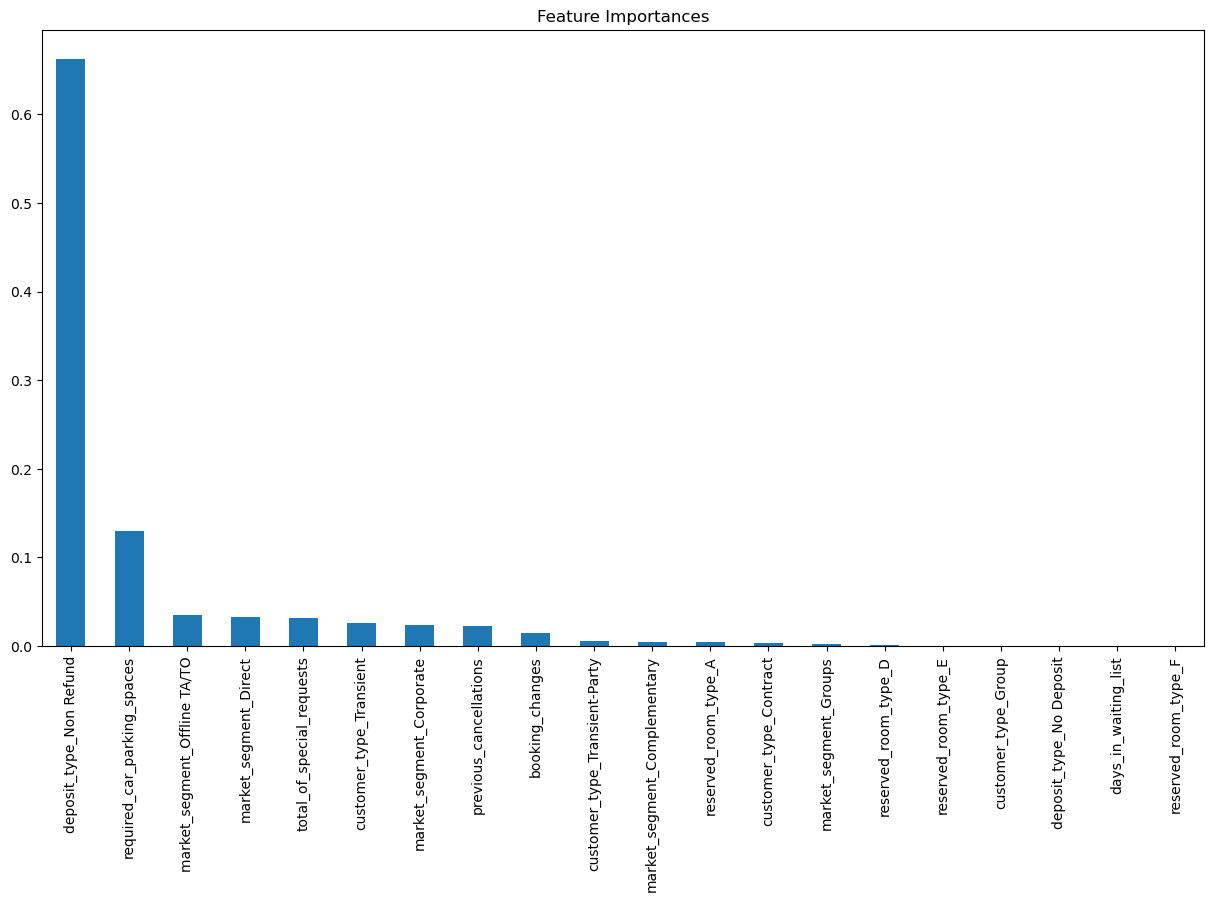

In [45]:
# Get feature importance from the best model
best_model = best_model_adjusted.model.named_steps['classifier']


feature_names = best_model_adjusted.model.named_steps['feature_selection'].get_support(indices=True)
selected_feature_names = np.array(feat_cols)[feature_names]


model_coef1 = pd.Series(best_model.feature_importances_, selected_feature_names).sort_values(ascending = False)
plt.figure(figsize=(15,8))
model_coef1.iloc[:50].plot(kind='bar', title='Feature Importances')
plt.show()

The plot above shows feature importance based on **gain-based importance**, which shows how much each feature contributes to reducing loss in the model.

**Insight**
1. **Deposit Type - "Non Refund" is the Most Influential Factor**: Customers who select non-refundable bookings are significantly less likely to cancel. 
2. **Required Car Parking Spaces Reduces Cancellation Probability**: Guests requesting parking are more committed to their travel plans.
3. **Market Segment Plays a Crucial Role in Cancellations**: Some segments, such as Offline TA/TO and Direct bookings, have a higher influence on cancellation likelihood.
4. **Previous Cancellations and Special Requests Matter**: Customers with prior cancellations are more likely to cancel again, while more special requests can indicate either serious intent or potential future cancellations.

**Business Implications**:
- **Encourage Non-Refundable Deposits for Lower Cancellation Rates**: Hotels should offer discounts or perks to incentivize customers to choose "Non-Refundable" options.
- **Optimize Marketing and Pricing Strategies for Different Market Segments**: Identify which segments contribute the most to cancellations and adjust pricing or policies accordingly.
- **Implement More Stringent Policies for Customers with Cancellation History**: Offer better incentives for returning customers with good booking history while adding stricter conditions for those with high cancellations.


100%|===================| 66854/66858 [11:07<00:00]        

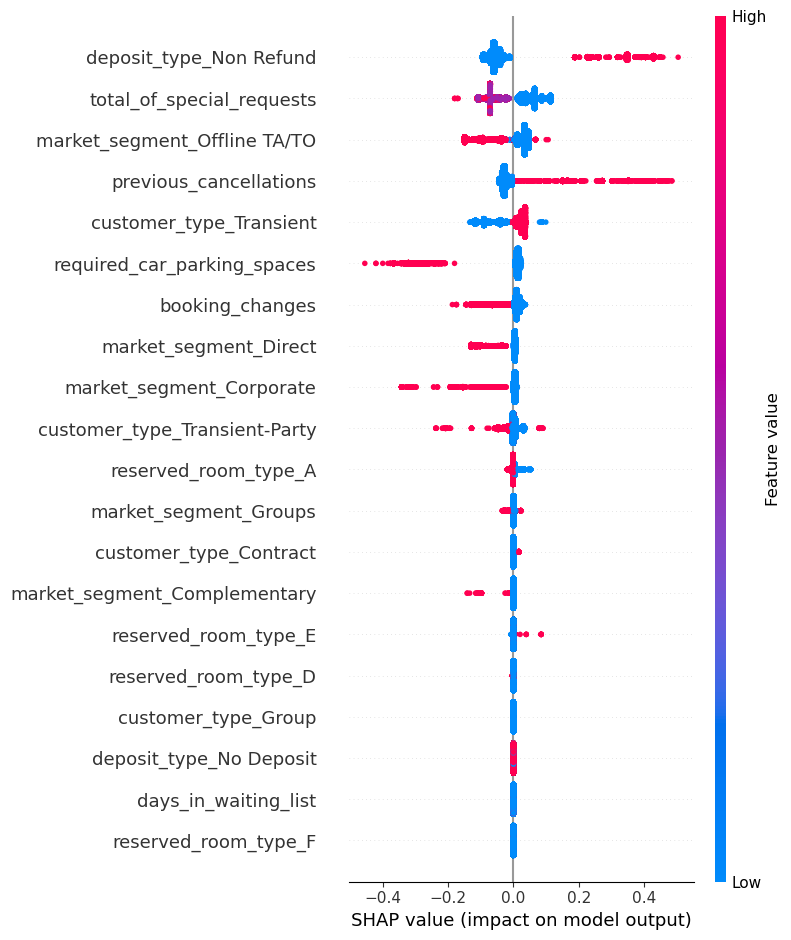

In [46]:
# Apply preprocessing to the training data
X_train_preprocessed = best_model_adjusted.model.named_steps['preprocessor'].transform(X_train)

# Apply feature selection to the preprocessed data
X_train_selected = best_model_adjusted.model.named_steps['feature_selection'].transform(X_train_preprocessed)

# Get the feature names after selection
feature_names = best_model_adjusted.model.named_steps['feature_selection'].get_support(indices=True)
selected_feature_names = np.array(feat_cols)[feature_names]

# Get feature importance from the best model
best_model = best_model_adjusted.model.named_steps['classifier']

X_train_selected=pd.DataFrame(X_train_selected)
X_train_selected.columns=selected_feature_names

# X_train_selected
shap_values=shap.TreeExplainer(best_model,data=X_train_selected,model_output='probability').shap_values(X_train_selected)

#plot shap
shap.summary_plot(shap_values,X_train_selected, feature_names=X_train_selected.columns)

The above plot presents **SHAP values**, which explain how each feature contributes to a single prediction rather than just global importance.

**Insight**
1. **Deposit Type - "Non Refund" Has the Highest Impact on Predictions**: Reinforces that non-refundable bookings strongly reduce cancellations.
2. **Total Special Requests Have Mixed Effects**: Special requests sometimes indicate serious intent, but excessive requests may correlate with higher cancellations.
3. **Market Segment Significantly Affects Cancellation Probability**: Offline TA/TO bookings show a high impact, while direct and corporate bookings behave differently.
4. **Previous Cancellations Are a Strong Predictor**: Customers with a history of cancellations are much more likely to cancel again.

**Business Implications**:
1. **Use Personalized Marketing Strategies Based on Market Segments & Customer Type**: Reduce cancellations by offering flexible policies to transient and party travelers, while reinforcing stricter policies for frequently canceling customer types.
2. **Incentivize Customers with Low Cancellation History to Encourage Repeat Business**: Provide discounts or loyalty perks for those with good booking records.
3. **Analyze & Adjust Policies for Special Requests**: Determine which types of special requests correlate with higher cancellations and adjust fulfillment strategies accordingly.


### Business Outcome Evaluation

To calculate the amount of revenue saved by by implementing the adjusted-threshold model, the number of 
- **False Positives** (predicting cancellation when the customer wouldn't cancel), and 
- **False Negatives** (predicting no cancellation when the customer cancels)

must first be calculated from the confusion matrix.

XGBoost Confusion Matrix:


None

True Positives: 5736
True Negatives: 4600
False Positives: 5959
False Negatives: 420


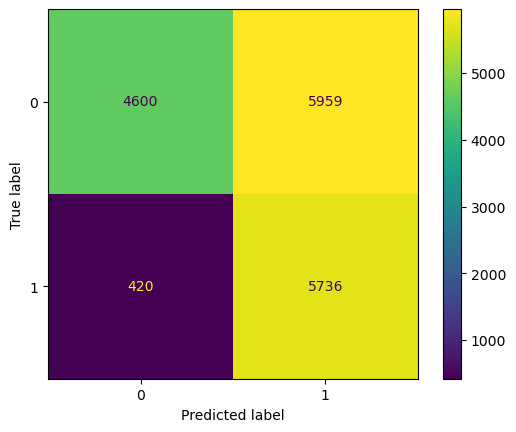

In [53]:
# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_adjusted).ravel()

# Display the Confusion Matrix
print("XGBoost Confusion Matrix:")
display(display(ConfusionMatrixDisplay.from_predictions(y_test, y_pred_adjusted)))

# Print the results
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


Next, it is assumed that:
- the average revenue per booking is **$100** and,
- last-minute rebooking may only recover **50% of the revenue**

In [48]:
# Assumptions
average_booking_revenue = 100  # Revenue per booking
recovery_rate = 0.5  # Recovery rate if a booking is canceled

# Revenue loss per missed cancellation (False Negative)
revenue_loss_per_FN = average_booking_revenue * (1 - recovery_rate)

# Revenue saved by correctly predicting cancellations
revenue_saved_by_model = tp * revenue_loss_per_FN

# Print the revenue saved
print(f"Total revenue saved by implementing the model: ${revenue_saved_by_model:,.2f}")

Total revenue saved by implementing the model: $286,800.00


By correctly identifying cancellations, the model helps the hotel save approximately **$286,800** that would have otherwise been lost. 

This demonstrates the financial benefit of using the adjusted treshold model to optimize booking management and reduce the revenue loss arising from cancellations.

### Model Constraints

Despite the potential financial benefits, it is important to remember that the model only works within the constraints of the features present in the training dataset used to fit the model.

Here are the data limitations that the model can accept for prediction.

In [49]:
X.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211
std,0.841011,0.648635,17.673051,0.246919,0.795163
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000


In [50]:
#Melihat unique values pada data train
pd.set_option('display.max_colwidth', None)

columns = ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']
values = []
nunique_list = []
for i in columns:
    value = X[i].unique()
    nunique = X[i].nunique()
    nunique_list.append(nunique)
    values.append(value)

display(
    pd.DataFrame({
    "columns" : columns,
    "values" : values,
    "nunique": nunique_list
})
       )
pd.reset_option('display.max_colwidth')

,columns,values,nunique
0,market_segment,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation, Undefined]",8
1,deposit_type,"[No Deposit, Non Refund, Refundable]",3
2,customer_type,"[Transient-Party, Transient, Contract, Group]",4
3,reserved_room_type,"[A, E, D, F, B, G, C, H, L, P]",10


The model only works if it is predicting cancellation on dataset with the following constraints:

| Feature  | Value Range (for Numerical Data)                        | Allowed Values (for Categorical Data)   |
|-----------|--------------------------------------|-----------------------------------------------------------------------------------------------------------------------------|
| Previous Cancellations      | 0 - 26                              | -   |
| Booking Changes   | 0 - 21                        | - |
| No. of Days in Waiting List | 0 - 391                              | -   |
| Required Car Parking Spaces	     | 0 - 8                             | - |
| Total No. of Special Requests        | 0 - 5    | - |
| Market Segment   | -                                    | Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation, Undefined |
| Deposit Type     | -                                    | No Deposit, Non Refund, Refundable |
| Customer Type   | -                                    | Transient-Party, Transient, Contract, Group |
| Reserved Room Type    | -                                    | A, E, D, F, B, G, C, H, L, P |

## Model Deployment

The adjusted treshold model is fitted on the entire dataset (`X` and `y`) before it is saved using the `pickle` package.

A `streamlit` interface is created so that the stakeholders can interface with the classification model to predict booking cancellation. The `streamlit` app can be accessed [here](https://booking-cancellation-capstone3purwadhikajcds2704009.streamlit.app/).

In [51]:
# Get the best model with adjusted probability threshold
best_estimator = best_model_adjusted

#Fit model to the entire X and y set
best_estimator.model.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [52]:
# Instantiate model name
filename = 'final_model.sav'

# Save the model using pickle
pickle.dump(best_estimator,open(filename,'wb'))

## Conclusion and Recommendation

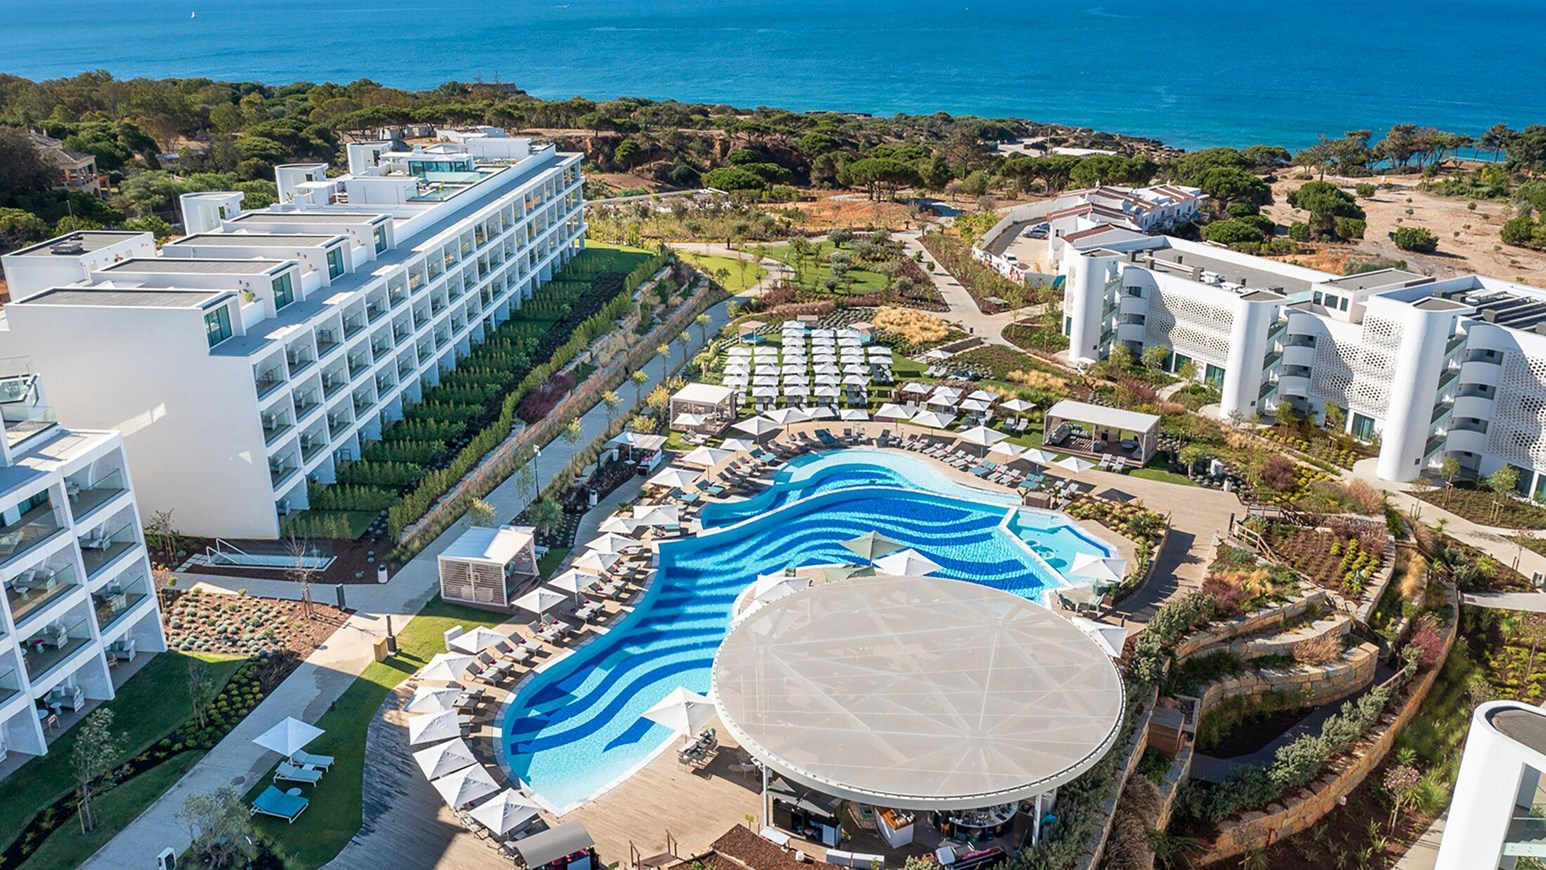

### CONCLUSION

The XGBoost model with its hyperparameter tuned and probability threshold adjusted has the best performance in predicting the likelihood of booking cancellation using only 10 features after going through the data preprocessing stage compared to the other 9 classification methods. This can be seen from the $F2$-score value of the model (**~0.79**) which indicates that the model is able to balance both recall and precision values. 

Financially speaking, by using the adjusted threshold model, the hotel management revenue team is able to save **$286,800** by correctly predicting booking cancelation.

### Recommendation

**Business Recommendation**

By analyzing both the feature importance and SHAP value plots, as well as understanding that the best model has its **probability threshold** adjusted to **0.35**, the following business recommendations can be made:

1. **Leverage Non-Refundable Deposits to Minimize Cancellations**
    - Offer discounts, early-bird deals, or room upgrades for customers choosing non-refundable bookings.
2. **Segment Customers and Market Accordingly**
    - Optimize pricing, cancellation policies, and targeted promotions based on market segments and booking behaviors.
3. **Implement a Risk-Based Booking System**
    - Introduce dynamic pricing or cancellation penalties for customers with a history of cancellations.

### Model Improvement Recommendation

To improve the Machine Learning performance, the following recommendations are put forward:

1. **Incorporate Time-Based Patterns**: Enrich the data by incorporating booking seasonality trends (such as yearly/monthly data) to detect seasonal spikes in cancellation, as well as incorporating rolling cancellation trends per customer to capture changing behaviors.
2. **Try Alternative Models for Comparison**: Test other classification algorithms (e.g., Deep-Learning) to observe if other algorithms produce better classification results.

## References
- Antonio, N., de Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in Brief, 22, 41–49. DOI: 10.1016/j.dib.2018.11.126

- Antonio, N., de Almeida, A., & Nunes, L. (2017). Predicting hotel bookings cancellation with a machine learning classification model. In 16th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 1049-1054). IEEE. DOI: 10.1109/ICMLA.2017.00-11

- Binesh, F., Belarmino, A., & Raab, C. (2020). A meta-analysis of hotel revenue management. Journal of Revenue and Pricing Management, 20, 546–558. DOI: 10.1057/s41272-020-00268-w

- Lin, Y. (2023). Research on the Influencing Factors of Cancellation of Hotel Reservations. Highlights in Science, Engineering and Technology, Volume 61, IFMPT 2023, 107-117

- Rahmawati, E., Nurohim, G. S., Agustina, C., Irawan, D., & Muttaqin, Z. (2024). Development of Machine Learning Model to Predict Hotel Room Reservation Cancellations. Jurnal Teknologi Informasi Dan Terapan (J-TIT), 11(2), 58-64. DOI: 10/25047/jtit.v11i2.5440